In [1]:
!pip install librosa

In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow

In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [4]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Eager Execution:", tf.executing_eagerly())

TensorFlow Version: 2.19.0
Eager Execution: True


In [5]:
!wget -O release_in_the_wild.zip "https://owncloud.fraunhofer.de/index.php/s/JZgXh0JEAF0elxa/download"

--2025-04-04 08:21:08--  https://owncloud.fraunhofer.de/index.php/s/JZgXh0JEAF0elxa/download
Resolving owncloud.fraunhofer.de (owncloud.fraunhofer.de)... 153.97.181.47
Connecting to owncloud.fraunhofer.de (owncloud.fraunhofer.de)|153.97.181.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8161489023 (7.6G) [application/zip]
Saving to: ‘release_in_the_wild.zip’

release_in_the_wild 100%[===================>]   7.60G  30.3MB/s    in 4m 57s  

2025-04-04 08:26:05 (26.2 MB/s) - ‘release_in_the_wild.zip’ saved [8161489023/8161489023]



In [6]:
!unzip release_in_the_wild.zip -d /content/release_in_the_wild

Streaming output truncated to the last 5000 lines.
  inflating: /content/release_in_the_wild/release_in_the_wild/22251.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/22472.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/21437.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/1451.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/9082.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/20810.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/4210.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/12376.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/2772.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/22039.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/9847.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/15569.wav  
  inflating: /content/release_in_the_wild/release_in_the_wild/8969

In [8]:
!ls /content/release_in_the_wild

release_in_the_wild


In [9]:
# Step 2: Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [10]:
# Step 3: Define the audio directory and load metadata
# Update the metadata path if necessary. If your metadata CSV is part of the ZIP, update its location.
# audio_dir = '/content/release_in_the_wild'
audio_dir = '/content/release_in_the_wild/release_in_the_wild/'   # Updated audio directory path to the nested folder
metadata_path = '/content/meta.csv'  # Adjust this if your CSV is elsewhere

In [11]:
metadata = pd.read_csv("/content/meta.csv")

In [12]:
# Step 4: Define the feature extraction function
def extract_features(file_path, max_pad_len=128):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None
    try:
        audio, sr = librosa.load(file_path, sr=None)
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        if mel_spec_db.shape[1] < max_pad_len:
            pad_width = max_pad_len - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :max_pad_len]
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [13]:
!find /content/release_in_the_wild -type f

Streaming output truncated to the last 5000 lines.
/content/release_in_the_wild/release_in_the_wild/22251.wav
/content/release_in_the_wild/release_in_the_wild/22472.wav
/content/release_in_the_wild/release_in_the_wild/21437.wav
/content/release_in_the_wild/release_in_the_wild/1451.wav
/content/release_in_the_wild/release_in_the_wild/9082.wav
/content/release_in_the_wild/release_in_the_wild/20810.wav
/content/release_in_the_wild/release_in_the_wild/4210.wav
/content/release_in_the_wild/release_in_the_wild/12376.wav
/content/release_in_the_wild/release_in_the_wild/2772.wav
/content/release_in_the_wild/release_in_the_wild/22039.wav
/content/release_in_the_wild/release_in_the_wild/9847.wav
/content/release_in_the_wild/release_in_the_wild/15569.wav
/content/release_in_the_wild/release_in_the_wild/8969.wav
/content/release_in_the_wild/release_in_the_wild/21759.wav
/content/release_in_the_wild/release_in_the_wild/19010.wav
/content/release_in_the_wild/release_in_the_wild/19318.wav
/content/re

In [14]:
# Step 5: Extract features and labels from the audio files
# Updated audio directory path to the nested folder

# Extract features and labels from the audio files
X, y = [], []
for index, row in metadata.iterrows():
    file_path = os.path.join(audio_dir, row['file'])
    label = row['label']
    features = extract_features(file_path)
    if features is not None:
        X.append(features)
        y.append(label)

X = np.array(X)
y = np.array(y)


In [15]:
import os

# List a few files from the extracted directory
print(os.listdir(audio_dir)[:10])

# Print the first few rows of the metadata
print(metadata.head())


['10882.wav', '21886.wav', '389.wav', '6604.wav', '5848.wav', '3894.wav', '31331.wav', '31404.wav', '12407.wav', '23119.wav']
    file               speaker      label
0  0.wav         Alec Guinness      spoof
1  1.wav         Alec Guinness      spoof
2  2.wav          Barack Obama      spoof
3  3.wav         Alec Guinness      spoof
4  4.wav  Christopher Hitchens  bona-fide


In [16]:
# Reshape input for CNN (adding channel dimension)
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Add a channel dimension to the input data
X = X[..., np.newaxis]


In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert integers to one-hot encoding
y_one_hot = to_categorical(y_encoded)


In [18]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2], 1)),  # Explicit input layer
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),N
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y_one_hot.shape[1], activation='softmax')  # Number of classes as output units
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 642s 805ms/step - accuracy: 0.6026 - loss: 9.3859 - val_accuracy: 0.6509 - val_loss: 0.5890
Epoch 2/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 672s 793ms/step - accuracy: 0.6843 - loss: 0.5560 - val_accuracy: 0.7074 - val_loss: 0.4816
Epoch 3/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 730s 853ms/step - accuracy: 0.7163 - loss: 0.4862 - val_accuracy: 0.7124 - val_loss: 0.4658
Epoch 4/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 615s 774ms/step - accuracy: 0.7188 - loss: 0.4655 - val_accuracy: 0.7170 - val_loss: 0.4797
Epoch 5/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 622s 774ms/step - accuracy: 0.7279 - loss: 0.4523 - val_accuracy: 0.7155 - val_loss: 0.4683
Epoch 6/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 623s 776ms/step - accuracy: 0.7348 - loss: 0.4363 - val_accuracy: 0.7560 - val_loss: 0.4316
Epoch 7/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 616s 768ms/step - accuracy: 0.7593 - loss: 0.4182 - val_accuracy: 0.7289 - val_loss: 0.4407
Epoch 8/20
795/795 ━━━━━━━━━━━━━━━━━━━━ 610s 767ms/step - accuracy: 0.7281 -

In [21]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - accuracy: 0.9870 - loss: 0.0521
Test Accuracy: 98.79%


Plot Training History

Visualize how accuracy and loss evolved during training:

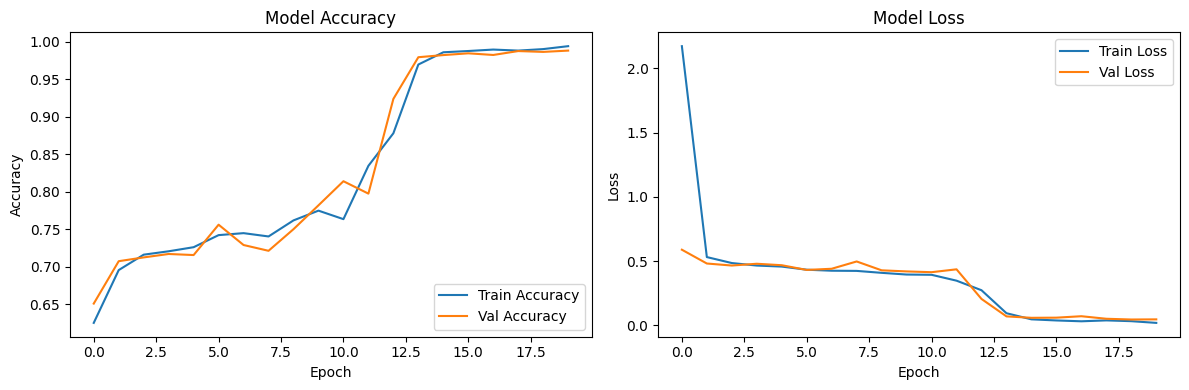

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [26]:
#Save the Model

import keras.saving
keras.saving.save_model(model, 'model.keras')
